In [1]:
import torch
import numpy

In [2]:
def Dinvmatrix_torch(N):
    """produces a causal inverse delay matrix D^{-1}(z), which has 
    delays z^-1  on the lower half in 3D polynomial representation (exponents of z^-1 are in third dimension)
    N is the number of subbands and size of the polynomial matrix (NxN)
    N is even"""
    D = torch.zeros((N,N,2))
    D[:,:,0] = torch.diag((torch.cat((torch.ones((int(N/2))),torch.zeros((int(N/2)))))))
    D[:,:,1] = torch.diag((torch.cat((torch.zeros((int(N/2))),torch.ones((int(N/2)))))))
    return D

In [3]:
def Dmatrix_torch(N):
    """produces a delay matrix D(z), which has delay z^-1 on the upper half of its diagonal
    in a 3D polynomial representation (exponents of z^-1 are in the third dimension) 
    N is number of subbands and size of the polynomial matrix (NxN) 
    N is even""" 
    D=torch.zeros((N,N,2))
    D[:,:,0] = torch.diag(torch.cat((torch.zeros((int(N/2))), torch.ones((int(N/2))))))
    D[:,:,1] = torch.diag(torch.cat((torch.ones((int(N/2))), torch.zeros((int(N/2))))))
    return D

In [4]:
def symFmatrix_torch(f):
    """produces a diamond shaped folding matrix F from the coefficients f
    (f is a 1-d array)
    which leads to identical analysis and synthesis baseband impulse responses
    Hence has det 1 or -1
    If N is number of subbands, then f is a vector of size 1.5*N coefficients.
    N is even
    returns: F of shape (N,N,1)
    """   
    sym=1.0; #The kind of symmetry: +-1
    N = int(len(f)/1.5);
    F=torch.zeros((N,N,1))
    F[0:int(N/2),0:int(N/2),0]=torch.fliplr(torch.diag(f[0:int(N/2)]))
    F[int(N/2):N,0:int(N/2),0]=torch.diag(f[int(N/2):N])
    F[0:int(N/2),int(N/2):N,0]=torch.diag(f[N:(N+int(N/2))])
    f_rev = torch.flipud(f)
    ff = torch.flipud((sym*torch.ones((int(N/2))) - (f[N:(int(1.5*N))])*f_rev[int(N/2):N])/f[0:int(N/2)])    
    F[int(N/2):N,int(N/2):N,0]=-torch.fliplr(torch.diag(ff))
    return F

In [5]:
def polmatmult_torch( A,B ):
   """polmatmult(A,B)
   multiplies two polynomial matrices (arrays) A and B, where each matrix entry is a polynomial.
   Those polynomial entries are in the 3rd dimension
   The thirs dimension can also be interpreted as containing the (2D) coefficient
   exponent of z^-1.
   Result is C=A*B;"""  
   [NAx, NAy, NAz] = A.shape;
   [NBx, NBy, NBz] = B.shape;
   #Degree +1 of resulting polynomial, with NAz-1 and NBz-1 being the degree of the...
   Deg = NAz + NBz -1;
   C = torch.zeros((NAx,NBy,Deg));
   #Convolution of matrices:
   for n in range(0,(Deg)):
       for m in range(0,n+1):
           if ((n-m)<NAz and m<NBz):
               C[:,:,n] = C[:,:,n]+ torch.matmul(A[:,:,(n-m)].float(),B[:,:,m].float());
   return C

In [6]:
def polyphase2x_torch(xp):
   """Converts polyphase input signal xp (a row vector) into a contiguos row vector
   For block length N, for 3D polyphase representation (exponents of z in the third 
   matrix/tensor dimension)"""

   x=torch.reshape(xp,(1,1,-1))
   x=x[0,0,:]
   return x

In [7]:
def reshape_fortran(x, shape):
    if len(x.shape) > 0:
        x = x.permute(*reversed(range(len(x.shape))))
    return x.reshape(*reversed(shape)).permute(*reversed(range(len(shape))))

In [8]:
def x2polyphase_torch(x,N):
    """Converts input signal x (a 1D array) into a polyphase row vector 
    xp for blocks of length N, with shape: (1,N,#of blocks)"""     
    #Convert stream x into a 2d array where each row is a block:
    #xp.shape : (y,x, #num blocks):
    x=x[:int(len(x)/N)*N] #limit signal to integer multiples of N
    #xp=torch.reshape(x,(N,-1)) #order=F: first index changes fastest
    xp = reshape_fortran(x, (N,-1))
    #add 0'th dimension for function polmatmult:
    xp=torch.unsqueeze(xp, dim=0)
    return xp

In [9]:
from scipy.fft import dct, idct
from torch.autograd import Function


class DCT3Function(Function):
    @staticmethod
    def forward(ctx, input):
        scipy_input = input.detach().numpy()
        result = dct(scipy_input, type=3,axis=1,norm='ortho')
        return input.new(result)

    @staticmethod
    def backward(ctx, grad_output):
        numpy_go = grad_output.numpy()
        result = idct(numpy_go, type=3,axis=1,norm='ortho')
        return grad_output.new(result)

In [10]:
def dct3_torch(input):
    return DCT3Function.apply(input)

In [11]:
#The DCT4 transform:
def DCT4_torch(samples):
   #Argument: 3-D array of samples, shape (y,x,# of blocks), each row correspond to 1 row 
   #to apply the DCT to.
   #Output: 3-D array where each row ist DCT4 transformed, orthonormal.
   #use a DCT3 to implement a DCT4:
   r,N,blocks=samples.shape
   samplesup=torch.zeros((1,2*N,blocks))
   #upsample signal:
   samplesup[0,1::2,:]=samples
   y=dct3_torch(samplesup)*torch.sqrt(torch.tensor(2))
   return y[:,0:N,:]

In [12]:
def MDCTanafb_torch(x,N,fb):
   #MDCT analysis filter bank.
   #Arguments: x: input signal, e.g. audio signal, a 1-dim. array
   #N: number of subbands
   #fb: coefficients for the MDCT filter bank, for the F matrix, np.array with 1.5*N coefficients.
   #returns y, consisting of blocks of subband in in a 2-d array of shape (N,# of blocks)
   
   Fa=symFmatrix_torch(fb)
   D=Dmatrix_torch(N)
   y=x2polyphase_torch(x,N)
   y=polmatmult_torch(y,Fa)   
   y=polmatmult_torch(y,D)
   y=DCT4_torch(y)
   #strip first dimension:
   y=y[0,:,:]
   return y

fb= tensor([0.1951, 0.5556, 0.8315, 0.9808, 0.9808, 0.8315], requires_grad=True)


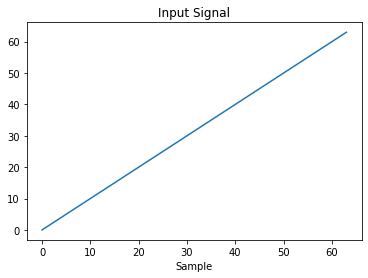

y=
 tensor([[-2.6850e-01,  4.3869e+00,  1.2387e+01,  2.0387e+01,  2.8387e+01,
          3.6387e+01,  4.4387e+01,  5.2387e+01,  6.0387e+01,  6.8387e+01,
          7.6387e+01,  8.4387e+01,  9.2387e+01,  1.0039e+02,  1.0839e+02,
          1.1639e+02,  1.0247e+02],
        [ 5.1576e-01, -1.1989e+00, -1.1989e+00, -1.1989e+00, -1.1989e+00,
         -1.1989e+00, -1.1989e+00, -1.1989e+00, -1.1989e+00, -1.1989e+00,
         -1.1989e+00, -1.1989e+00, -1.1989e+00, -1.1989e+00, -1.1989e+00,
         -1.1989e+00,  4.0095e+01],
        [-2.4517e-01, -3.3182e-01, -3.3182e-01, -3.3182e-01, -3.3182e-01,
         -3.3182e-01, -3.3182e-01, -3.3182e-01, -3.3182e-01, -3.3182e-01,
         -3.3182e-01, -3.3183e-01, -3.3183e-01, -3.3183e-01, -3.3183e-01,
         -3.3182e-01, -1.7405e+01],
        [-1.5015e-01,  8.2394e-02,  8.2394e-02,  8.2395e-02,  8.2395e-02,
          8.2396e-02,  8.2395e-02,  8.2395e-02,  8.2397e-02,  8.2397e-02,
          8.2400e-02,  8.2397e-02,  8.2406e-02,  8.2400e-02,  8.2406e-02,


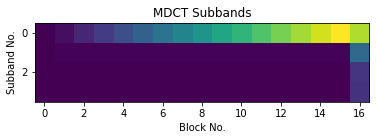

In [13]:
import matplotlib.pyplot as plt
import numpy as np
#Number of subbands:
N=4
D=Dmatrix_torch(N)
Dinv=Dinvmatrix_torch(N)
#Filter bank coefficients for sine window:
fb=torch.sin(torch.pi/(2*N)*(torch.arange(int(1.5*N))+0.5))
fb.requires_grad=True
print("fb=", fb)
#input test signal, ramp:
x=torch.arange(64).float()
x.requires_grad=True
plt.plot(x.detach().numpy())
plt.title('Input Signal')
plt.xlabel('Sample')
plt.show()
y=MDCTanafb_torch(x,N,fb); print("y=\n", y)
plt.imshow(np.abs(y.detach().numpy()))
plt.title('MDCT Subbands')
plt.xlabel('Block No.')
plt.ylabel('Subband No.')
plt.show()

In [14]:
def MDCTsynfb_torch(y,fb):
   #MDCT synthesis filter bank.
   #Arguments: y: 2-d array of blocks of subbands, of shape (N, # of blokcs)
   #returns xr, the reconstructed signal, a 1-d array.   
   
   N=y.shape[0]
   Fa=symFmatrix_torch(fb)
   #invert Fa matrix for synthesis after removing last dim:
   Fs=torch.linalg.inv(Fa[:,:,0])
   #add again last dimension for function polmatmult:
   Fs=torch.torch.unsqueeze(Fs, dim=-1)
   Dinv=Dinvmatrix_torch(N)

   #add first dimension to y for polmatmult:
   y=torch.unsqueeze(y,dim=0)
   xp=DCT4_torch(y)
   xp=polmatmult_torch(xp,Dinv)
   xp=polmatmult_torch(xp,Fs)
   xr=polyphase2x_torch(xp)
   return xr

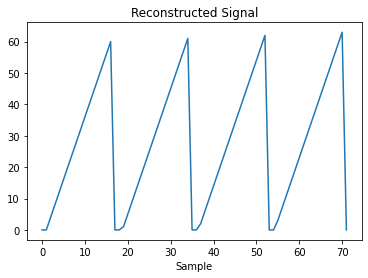

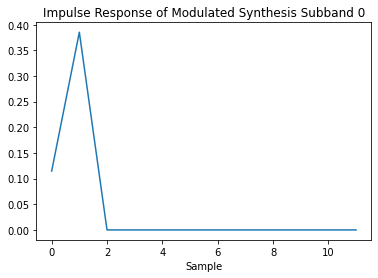

In [15]:
xr=MDCTsynfb_torch(y,fb)
plt.plot(xr.detach().numpy())
plt.title('Reconstructed Signal')
plt.xlabel('Sample')
plt.show()
y=torch.zeros((4,16))
y[0,0]=1
xr=MDCTsynfb_torch(y,fb)
plt.plot(xr[0:3*N].detach().numpy())
plt.title('Impulse Response of Modulated Synthesis Subband 0')
plt.xlabel('Sample')
plt.show()

In [16]:
# Test Differentiability

In [27]:
# -*- coding: utf-8 -*-
import torch
import math
import random


class Polynomial3(torch.nn.Module):
    def __init__(self):
        """
        In the constructor we instantiate four parameters and assign them as
        member parameters.
        """
        super().__init__()
        self.a = torch.nn.Parameter(torch.randn(()))
        self.b = torch.nn.Parameter(torch.randn(()))
        self.c = torch.nn.Parameter(torch.randn(()))
        self.d = torch.nn.Parameter(torch.randn(()))


    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        x_pred = self.a + self.b * x + self.c * x ** 2 + self.d * x ** 3
        fb=torch.sin(torch.pi/(2*N)*(torch.arange(int(1.5*N))+0.5))
        fb.requires_grad=True
        y_pred__mdct=MDCTanafb_torch(x_pred,N,fb)
        return x_pred, y_pred__mdct

    def string(self):
        """
        Just like any class in Python, you can also define custom method on PyTorch modules
        """
        return f'y = {self.a.item()} + {self.b.item()} x + {self.c.item()} x^2 + {self.d.item()} x^3'


# Create Tensors to hold input and outputs.
x = torch.linspace(-math.pi, math.pi, 4000)
x.requires_grad=True
y = torch.sin(x)
N=4
fb=torch.sin(torch.pi/(2*N)*(torch.arange(int(1.5*N))+0.5))
fb.requires_grad=True
y_mdct=MDCTanafb_torch(x,N,fb)


# Construct our model by instantiating the class defined above
model = Polynomial3()

# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters (defined 
# with torch.nn.Parameter) which are members of the model.
criterion1 = torch.nn.MSELoss(reduction='sum')
criterion2 = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-6)
for t in range(1000):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred, y_pred_mdct = model(x)

    # Compute and print loss
    loss = criterion1(y_pred,y) + 0.001*criterion2(y_pred_mdct, y_mdct)
    
    if t % 100 == 99:
        print(t, loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()

print(f'Result: {model.string()}')

99 5649.6240234375
199 2521.945556640625
299 1135.68310546875
399 520.0980224609375
499 246.16879272460938
599 123.99153137207031
699 69.36038208007812
799 44.864601135253906
899 33.84794235229492
999 28.877323150634766
Result: y = -0.02650148794054985 + 0.8202168941497803 x + 0.004574332386255264 x^2 + -0.08803033828735352 x^3


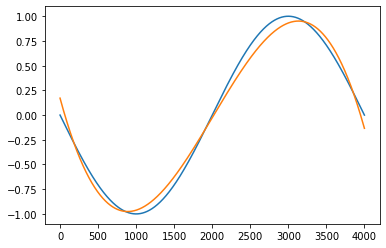

In [28]:
plt.figure()
plt.plot(y.detach().numpy())
plt.plot(y_pred.detach().numpy())


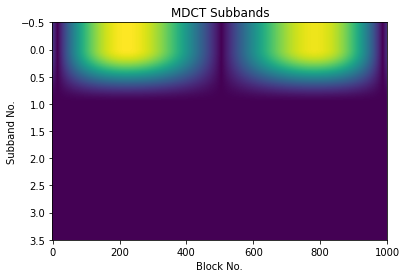

In [29]:
plt.figure()
plt.imshow(np.abs(y_pred_mdct.detach().numpy()), aspect='auto')
plt.title('MDCT Subbands')
plt.xlabel('Block No.')
plt.ylabel('Subband No.')
plt.show()

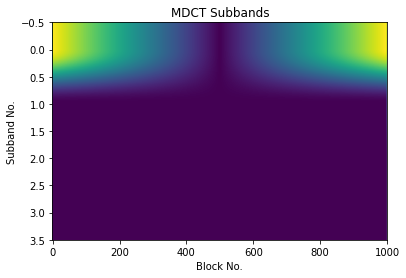

In [30]:
plt.figure()
plt.imshow(np.abs(y_mdct.detach().numpy()), aspect='auto')
plt.title('MDCT Subbands')
plt.xlabel('Block No.')
plt.ylabel('Subband No.')
plt.show()